CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
!pip install torchsummary

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 105785768.70it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57904251.35it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35919244.81it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6115739.57it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

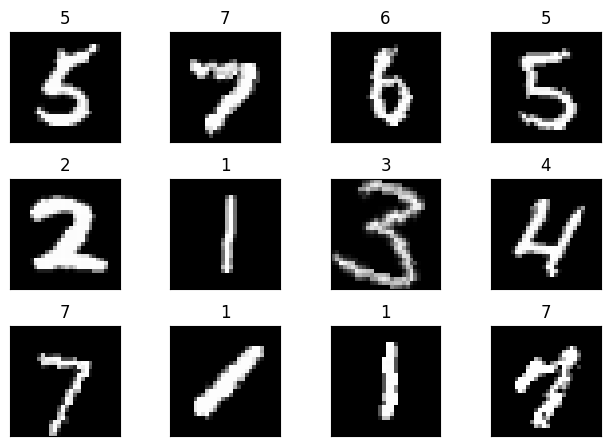

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [80]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after the first convolutional layer
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(24)  # Batch normalization after the second convolutional layer
        self.conv2_1 = nn.Conv2d(24, 16, kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(16)  # Batch normalization after the second 1x1 convolutional layer
        self.conv3 = nn.Conv2d(16, 20, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm2d(20)  # Batch normalization after the third convolutional layer
        self.conv4 = nn.Conv2d(20, 25, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(25)  # Batch normalization after the fourth convolutional layer
        self.conv4_1 = nn.Conv2d(25, 20, kernel_size=1)
        self.bn4_1 = nn.BatchNorm2d(20)  # Batch normalization after the fourth 1x1 convolutional layer
        self.conv5 = nn.Conv2d(20, 30, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(30)
        self.conv6 = nn.Conv2d(30, 10, kernel_size=3)

        self.dropout = nn.Dropout2d(p=0.1)  # Minimal dropout with 10% probability

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Layer Name : Conv1-BatchNorm-Relu,channel_size : 26, Receptive Field : 2
        x = self.dropout(x) # Dropout 1, channel_size : 26, Receptive Field : 2
        x = F.relu(self.bn2(self.conv2(x)))  # Layer Name : Conv2-BatchNorm-Relu, channel_size : 24, Receptive Field : 4
        x = self.dropout(x) # Dropout 2, channel_size : 24, Receptive Field : 4
        x = F.max_pool2d(x, 2)  # Layer Name : MaxPooling, channel_size : 12, Receptive Field : 5
        x = F.relu(self.bn2_1(self.conv2_1(x)))  # Layer Name : ChanelReductionConv2_1-BatchNorm-Relu, channel_size : 12, Receptive Field : 5
        x = F.relu(self.bn3(self.conv3(x)))  # Layer Name : Conv3-BatchNorm-Relu, channel_size : 12, Receptive Field : 9
        x = F.relu(self.bn4(self.conv4(x)))  # Layer Name : Conv4-BatchNorm-Relu, channel_size : 10, Receptive Field : 13
        x = F.max_pool2d(x, 2)  #Layer Name : MaxPooling, channel_size : 5, Receptive Field : 15
        x = F.relu(self.bn4_1(self.conv4_1(x)))  #Layer Name : ChanelReductionConv4_1-BatchNorm-Relu, channel_size : 5, Receptive Field : 15
        x = F.relu(self.bn5(self.conv5(x)))# Layer Name : Conv5-BatchNorm-Relu, channel_size : 3, Receptive Field : 23
        x = self.conv6(x)# Layer Name : Conv6, channel_size : 1, Receptive Field : 31

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1) # Layer Name : Softmax


In [81]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 24, 24]           3,480
       BatchNorm2d-5           [-1, 24, 24, 24]              48
         Dropout2d-6           [-1, 24, 24, 24]               0
            Conv2d-7           [-1, 16, 12, 12]             400
       BatchNorm2d-8           [-1, 16, 12, 12]              32
            Conv2d-9           [-1, 20, 12, 12]           2,900
      BatchNorm2d-10           [-1, 20, 12, 12]              40
           Conv2d-11           [-1, 25, 10, 10]           4,525
      BatchNorm2d-12           [-1, 25, 10, 10]              50
           Conv2d-13             [-1, 20, 5, 5]             520
      BatchNorm2d-14             [-1, 2

CODE BLOCK: 8

In [83]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [84]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [85]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2419 Batch_id=117 Accuracy=79.52: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


Test set: Average loss: 0.1130, Accuracy: 9709/10000 (97.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2716 Batch_id=117 Accuracy=96.14: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


Test set: Average loss: 0.0616, Accuracy: 9839/10000 (98.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0430 Batch_id=117 Accuracy=97.20: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0462, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0533 Batch_id=117 Accuracy=97.64: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Test set: Average loss: 0.0378, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0230 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0336, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0586 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


Test set: Average loss: 0.0312, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0727 Batch_id=117 Accuracy=98.31: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0424 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0174 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Test set: Average loss: 0.0252, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0795 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0319 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0278 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0293 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0642 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0092 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0075 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0142 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0822 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0401 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0594 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

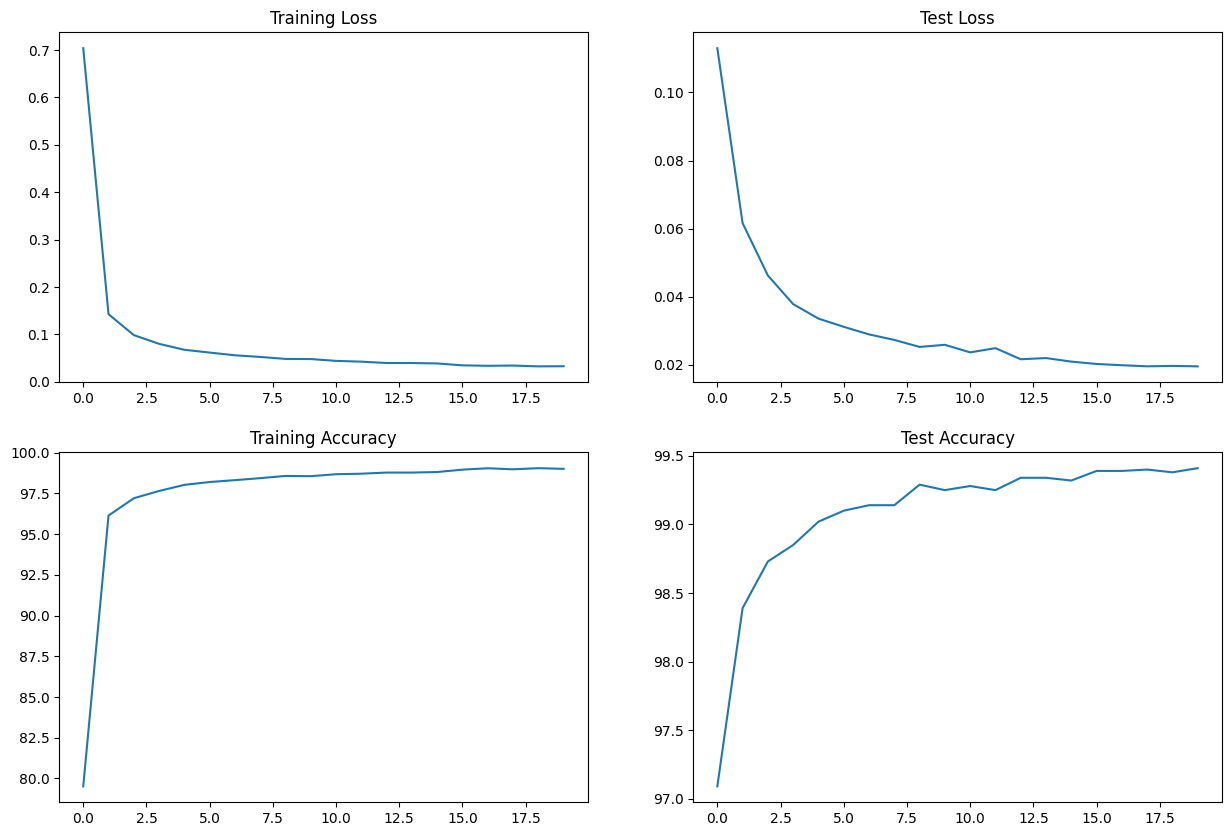

In [87]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [88]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 24, 24]           3,480
       BatchNorm2d-5           [-1, 24, 24, 24]              48
         Dropout2d-6           [-1, 24, 24, 24]               0
            Conv2d-7           [-1, 16, 12, 12]             400
       BatchNorm2d-8           [-1, 16, 12, 12]              32
            Conv2d-9           [-1, 20, 12, 12]           2,900
      BatchNorm2d-10           [-1, 20, 12, 12]              40
           Conv2d-11           [-1, 25, 10, 10]           4,525
      BatchNorm2d-12           [-1, 25, 10, 10]              50
           Conv2d-13             [-1, 20, 5, 5]             520
      BatchNorm2d-14             [-1, 2